# Network construction & Community detection--Twitter data

### We are given the data from tweeter, recording users' ID and the time and location when they post anything. Our basic idea is to construct a network where we observe the relation among places by analyzing people's activities near each location, trying to detect grouping communities and distinguish weak links from strong ones.

## Step 1,  load the data from twitter and categorize it by weekdays/weekend

In [1]:
%pwd

u'/Users/CQ/Documents/Project1'

In [1]:
__author__ = "Stephen"
__date__ = "2016_03_27"

import matplotlib.pyplot as plt
import networkx as nx
%pylab inline
import numpy as np
import pandas as pd
import geopandas as gp
from datetime import datetime, timedelta, date
import time
import csv
import community #Louvain method
import operator
import os

PWD = '/Users/CQ/Documents/Project1'

Populating the interactive namespace from numpy and matplotlib


Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


#### Some information about these files:
* twitter_file is the main database here, recording all tweeting activities from *Nov.4th 2015 to Feb.12th 2016*
* USzipcode is the dataframe containing zipcodes in U.S. but there are some zipcodes missing, and we will only provide analysis based on the zipcodes we have here in the database
* geo_NY is the shapefile for plotting, required by geopandas
* NOTE: For the majority of missing zipcodes, personal experience tells me that those zipcodes are usually parks or forests, in other words, the places where postal service is not needed much

In [2]:
twitter_file = pd.read_csv(PWD + '/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv(PWD + '/USzipcode_XY.csv')
zipPath = PWD + '/nyc-zip-code-tabulation-areas-polygons.geojson'
geo_NY = gp.read_file(zipPath)[['geometry', 'postalCode']]

#### Convert time stamp into time format and then categorize our data into four different datasets:
1. All data, labeled  All days with **date_index 0**
2. Data from weekdays, labeled  Weekdays with **date_index 1**
3. Data from Saturdays, labeled  Saturdays with **date_index 2**
4. Data from Sundays, labeled  Sundays with **date_index 3**

In [3]:
TimeList = range(4)
TimeList[0] = [time.localtime(x) for x in twitter_file.timestamp]
TimeList[1] = [x for x in TimeList[0] if x.tm_wday < 5]
TimeList[2] = [x for x in TimeList[0] if x.tm_wday == 5]
TimeList[3] = [x for x in TimeList[0] if x.tm_wday == 6]
twitter_file.iloc[:,0] = TimeList[0]

twitter_file.columns = ['DateTime','Stamp','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']

#### Change the columns' names as above, compute and filter the results, drop all zeros

In [4]:
def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

In [5]:
Data = range(4)
for i in range(4):
    Data[i] = twitter_file[twitter_file.DateTime.isin(TimeList[i])]
    Data[i] = Clean_zipcode(Data[i])

## Step 2, construct a network with the probability, or equivalently, the weight of link(a,b) defined as
### $$link(a,b) = \Sigma_c\frac{t(c,a)*(t(c,b)-\delta(a,b))}{T*(t(c)-1)}$$
### where
* *t(c,a)* denotes the total number of tweets that user *c* has posted at location (in our case, zipcode) *a*
* $t(c) = \Sigma_a t(c,a)$
* $T = \Sigma_c t(c)$

# Change 'for' to 'of'

In [11]:
Net, Net1, Net2 = range(4), range(4), range(4)
LABEL = ['All ','Week','Satur','Sun']
for i in range(4):
    Net1[i] = pd.read_csv(PWD + '/Network1/Network of '+LABEL[i]+'days.csv').iloc[:,1:]
    Net[i] = pd.read_csv(PWD + '/Network2/Network2 for '+LABEL[i]+'days.csv')
    Net[i].rename(columns={'Unnamed: 0':'UserID'}, inplace=True)

In [20]:
def Prob_Net(dataset):
    places = [int(x[-5:]) for x in list(dataset.columns)[1:]]
    T = dataset.iloc[:,1:].sum().sum()
    tc = dataset.iloc[:,1:].sum(axis = 1)
    #ix_tc is the index for tc > 1, so we can avoid having zero terms in denominator: (t(c) - 1) == 0
    ix_tc = tc > 1
    #the formula is provided above
    Prob_Net = np.zeros((len(places)**2, 3))
    for a in places:
        ix_a = places.index(a)
        for b in places:
            ix_b = places.index(b)
            delta = (ix_a == ix_b)+0
            w = 1.0 * dataset.iloc[:,ix_a+1][ix_tc] * (dataset.iloc[:,ix_b+1][ix_tc] - delta) / (tc[ix_tc]-1)
            Prob_Net[ix_a * len(places) + ix_b][0] = a
            Prob_Net[ix_a * len(places) + ix_b][1] = b
            Prob_Net[ix_a * len(places) + ix_b][2] = sum(w)/T
    result = pd.DataFrame(Prob_Net, columns = ['zip1','zip2','weight'])
    return result

for i in range(4):
    Net2[i] = Prob_Net(Net[i])
    Net2[i].to_csv(PWD + '/Network2/Network2 of '+LABEL[i]+'days.csv')

In [23]:
def Graph_build(network, date_index, directed = True):
    '''This function is for creating graphs based on the networks we have.
    The argument 'directed' indicates whether this graph is directed,
    default setting is True
    '''
    Graph = nx.DiGraph() if directed == True else nx.Graph()
    places = Data[date_index].ZipCode.unique()
    Graph.add_nodes_from(places)
    
    for i in range(len(network[date_index])):
        w = network[date_index].iloc[i,:]
        Graph.add_edge(w[0],w[1],weight = w[2])
    return Graph

#### Compared with our original network, here we label it as Network2

In [24]:
#add unit weights to unweighted network nodes
def make_directed_and_weighted(G):
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes())
    
    for e in G.edges():
        v1 = min(e[0],e[1])
        v2 = max(e[0],e[1])
        w = G[v1][v2]['weight']
        #if it's a loop edge, we double its weight
        if v1==v2:
            DG.add_edge(v1,v2, weight = 2 * w)
        #otherwise we set the weight of A->B equal to the weight of B->A
        else:
            DG.add_edge(v1,v2, weight = w)
            DG.add_edge(v2,v1, weight = w)
    return DG

## Step 3, proceed to community detection, first construct the directed graphs based on the probabilistic methods, then plot the graphs

#### Convert these dataframes into directed graphs, and then perform combo partition and community plotting to see the results

In [25]:
Graph, Graph1, Graph2 = range(4), range(4), range(4)
for i in range(4):
    Graph[i] = Graph_build(Net1,i,False)
    Graph1[i] = make_directed_and_weighted(Graph[i])
    Graph2[i] = Graph_build(Net2,i,True)

Start with Louvain method if curious but not necessary, next try combo algorithm with Inf, 2, and 4 communities parititions.
* We will run tests for graphs both with and without loop edges
* Please note that you may have to downgrade the version of package networkx from 1.11 to 1.9.1 in order to successfully plot the graph  (--week 3, March 3rd 2016)

In [26]:
workfolder = PWD + '/CommunityDetection'
os.chdir(workfolder)

In [27]:
#interface for running compiled combo over the network G given a maximal number of communities maxcom
def getComboPartition(G, maxcom):
    #save network in net format
    nodes={}
    nodenum={}
    i=0
    #create a dictionary transforming nodes to unique numbers
    for n in G.nodes():
        nodenum[n]=i
        nodes[i]=n
        i+=1
    f = open('combo/temp.net', 'w')
    f.write('*Arcs\n')
    for e in G.edges(data=True):
        f.write('{0} {1} {2}\n'.format(nodenum[e[0]],nodenum[e[1]],e[2]['weight']))
    f.close()
    #run combo
    command=workfolder+'/combo/comboCPP combo/temp.net'
    if maxcom<float('Inf'):
        command=command+' {0}'.format(maxcom)  
    os.system(command)
    #read resulting partition
    f = open('combo/temp_comm_comboC++.txt', 'r')
    i=0
    partition={}
    for line in f:
        partition[nodes[i]]=int(line)
        i+=1
    return partition

In [28]:
def modularity(G, partition):
    #compute network modularity according to the given partitioning
    nodes=G.nodes()
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0.0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
            if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                if G.has_edge(a,b):
                    e=G[a][b]['weight']
                else:
                    e=0
                M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M

In [29]:
def PartitionSorting(partition):
    ClusterList = [ (j, partition.values().count(j)*1.0/len(partition)) for j in set(partition.values())]
    ClusterList.sort(key = operator.itemgetter(1), reverse = 1)
    ClusterRanking = [i[0] for i in ClusterList]
    sorted_partition = {i:0 for i in partition.keys()}
    for i in sorted_partition.keys():
        sorted_partition[i] = ClusterRanking.index(partition[i]) + 1
    return sorted_partition

In [30]:
N_CP4, P_CP4 = range(4), range(4)
SN_CP4, SP_CP4 = range(4), range(4)
for i in range(4):
    N_CP4[i] = getComboPartition(Graph1[i], 4)
    P_CP4[i] = getComboPartition(Graph2[i], 4)
    SN_CP4[i] = PartitionSorting(N_CP4[i])
    SP_CP4[i] = PartitionSorting(P_CP4[i])

In [31]:
def PlotMapPart(fig, partition, date_index=0, zips=geo_NY, key='postalCode', cmap='spectral', title='Community Detection',size=221, alpha=.7):
    ax = fig.add_subplot(size + date_index)
    y = {i:'Community %d%d'%(partition[i]/10,partition[i]%10) for i in partition.keys()}
    p = pd.Series(y).reset_index().rename(columns={'index':'postalCode',0:'part'})
    zips.postalCode = zips.postalCode.astype(int)
    z = zips.merge(p, on=key, how='left')
    #z.loc[z.part.notnull(),'part'] = z[z.part.notnull()].part.astype(int)
    level = len(set(partition.values()))
    z[z.part.notnull()].plot(column = 'part', categorical=1, ax=ax, alpha=alpha, cmap = cmap, legend=True)
    plt.title(title, fontweight="bold", size=15)
    ax.axis('off')
    plt.subplots_adjust(hspace = 0.1, wspace = 0)

## Interesting observation here:
### The majority of the map is consistent regardless of the date, and both airports JFK&LaGuardia are labeled as the same color as midtown Manhattan for almost everyday, indicating high amount of Twitter activities. However, LaGuardia is more quite during weekends, while JFK has even higher activities on Saturdays due to the color consistency with lower Manhattan. I'm thinking maybe this results from 3 different possibilities:
1. International air traffic level on Saturdays is relatively higher than usual, while domestic level drops
2. Activity level in the city is relatively lower than usual on Saturdays
3. Our data is incomplete

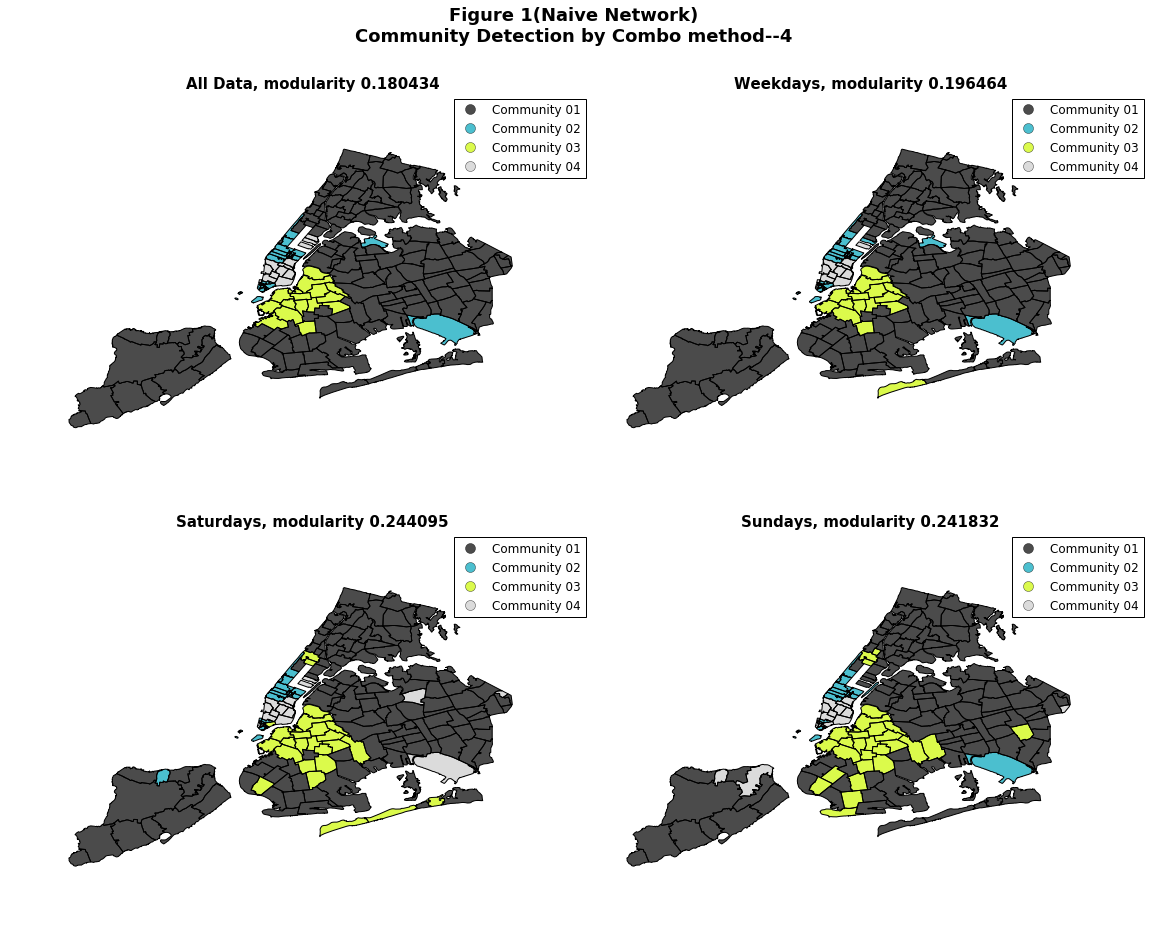

In [32]:
fig1 = plt.figure(num = 1, figsize = (20,15))
Title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
plt.suptitle('Figure 1(Naive Network)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    PlotMapPart(fig1, SN_CP4[i], date_index=i, title = Title[i]+', modularity %f' %modularity(Graph1[i],SN_CP4[i]))

## Some even more interesting observations here:
* During work days, some places in Brooklyn, e.g. Brooklyn Heights have almost same level of activity as Manhattan, but it drops significantly on Sundays; at the same time JFK's activity level is almost same as the Queens on Sundays, making me doubting even more about the aforementioned possibility of imcomplete data
* Lower Manhatten is always ranking highest, while Bronx and Queens are always at the bottom, with Staten Island and lower Brooklyn being second-to-last
* People from lower Brooklyn are usually active during weekdays, but not so much during weekends

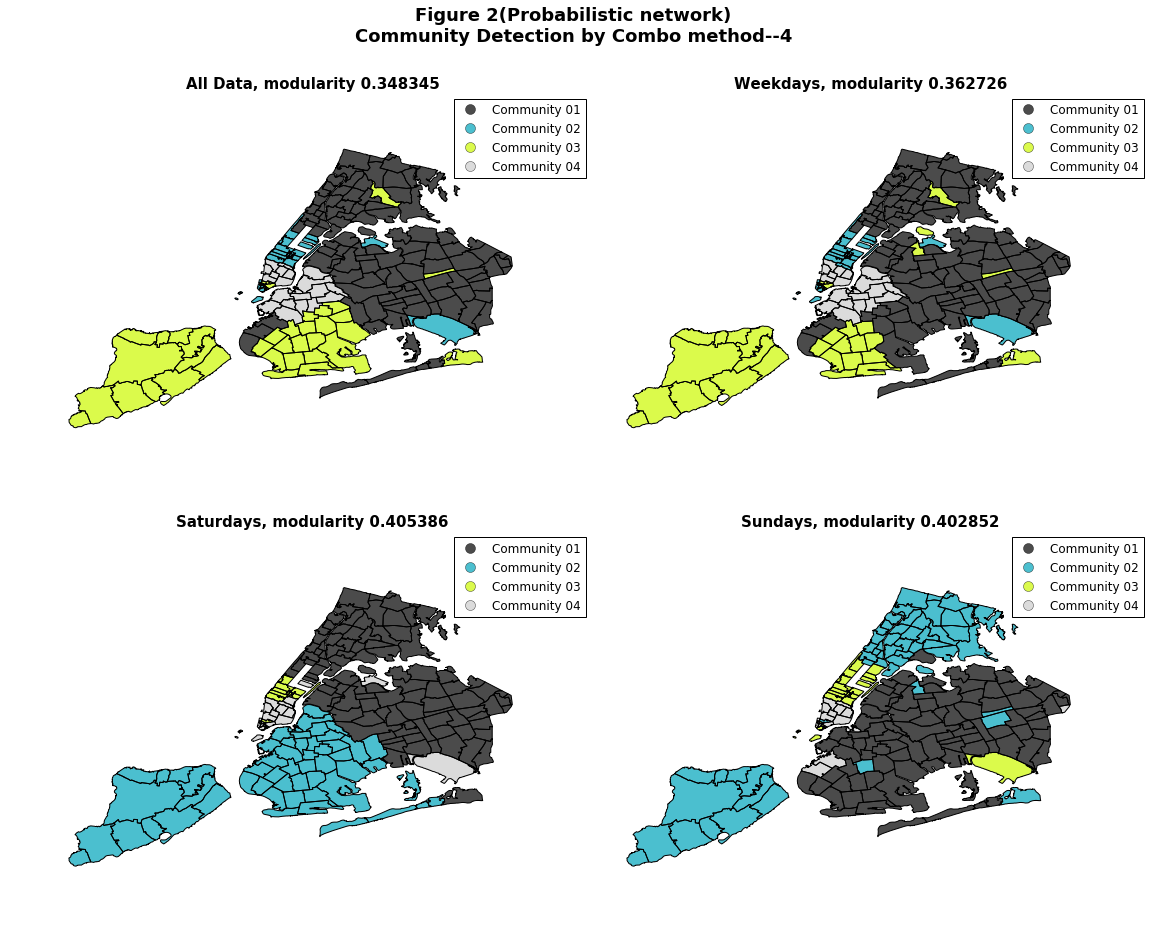

In [33]:
fig2 = plt.figure(num = 2, figsize = (20,15))
plt.suptitle('Figure 2(Probabilistic network)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    PlotMapPart(fig2, SP_CP4[i], date_index=i, title = Title[i]+', modularity %f' %modularity(Graph2[i],SP_CP4[i]))

## Step 4, some data visualization and demonstration

### A) First glance, twitter users' daily activities, with weekends highlighted

In [34]:
def DailyActivity():
    start_date = datetime.fromtimestamp(time.mktime(TimeList[0][0])).date()
    end_date = datetime.fromtimestamp(time.mktime(TimeList[0][-1])).date()
    day_count = (end_date-start_date).days
    DateList = [start_date + timedelta(n) for n in range(day_count)]
    T_ACT = {i:0 for i in DateList}
    for single_day in DateList:
        day_list = [x for x in Data[0].DateTime if datetime.fromtimestamp(time.mktime(x)).date() == single_day]
        T_ACT[single_day] = len(day_list)
    Thanksgiving = date(2015, 11, 26)
    Christmas = date(2015, 12, 25)
    NewYear = date(2016, 1, 1)
    a = Thanksgiving - start_date
    b = date(2015,12,1) - start_date
    c = Christmas - start_date
    d = NewYear - start_date
    e = date(2016,2,1) - start_date
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    ax.set_title("Daily Twitter Activities", fontweight="bold", size=18)
    bar = ax.bar(range(day_count), T_ACT.values(), color = ['g','g','g','r','r','g','g'] , align='center', width = 1.5)
    ax.legend((bar[0],bar[4]), ('Weekdays', 'Weekends'), loc = 2, prop={'size':18})
    ax.set_xticks([0,a.days, b.days, c.days, d.days, e.days])
    ax.set_xticklabels(['Nov/4/2015','Thanksgiving','Dec/1/2015','Christmas','New Year','Feb/1/2016'],
                       rotation=90, fontsize = 14)
    plt.show()

## This confirms that we do miss some data here as many days having "zero" activity which is clearly against common sense.

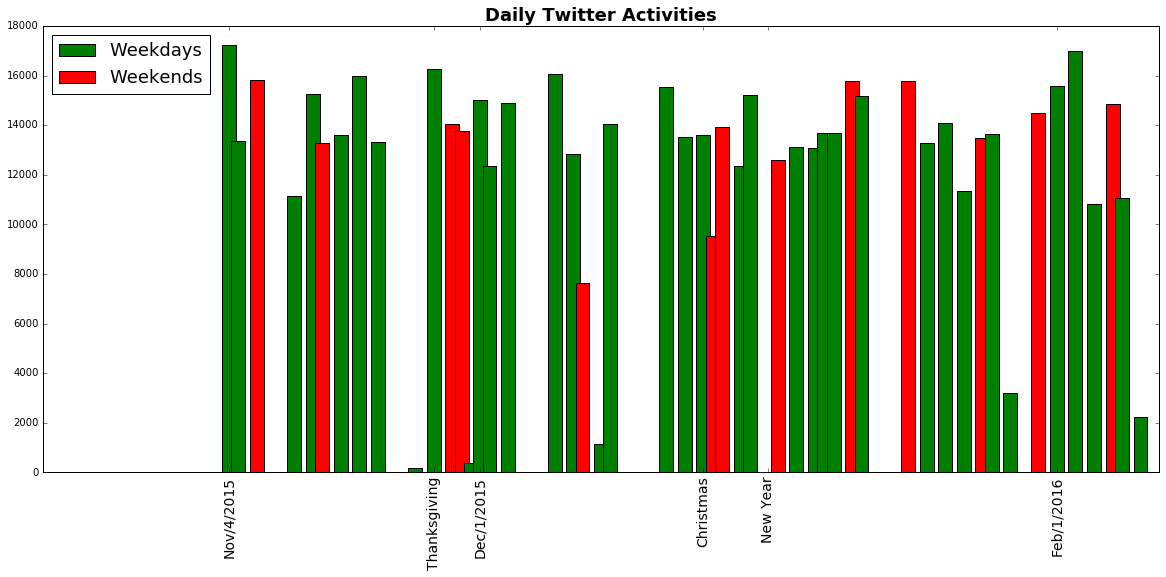

In [21]:
DailyActivity()

### B) Top places (zip codes) with highest amount of tweets, marked in map

In [69]:
#produce symmetrized undirected version of a directed network
def as_undirected(G):
    UG = nx.Graph()
    UG.add_nodes_from(G.nodes())
    for e in G.edges():
        UG.add_edge(e[0],e[1], weight = G[e[0]][e[1]]['weight'])
    return UG

In [70]:
PR1, PR2, UGraph1_PR, UGraph2_PR = range(4), range(4), range(4), range(4)
for i in range(4):
    PR2[i] = as_undirected(Graph2[i])
    UGraph1_PR[i] = list(nx.connected_component_subgraphs(Graph[i], copy=True))[0]
    PR1[i] = nx.pagerank(UGraph1_PR[i],0.85)
    UGraph2_PR[i] = list(nx.connected_component_subgraphs(PR2[i], copy=True))[0]
    PR2[i] = nx.pagerank(UGraph2_PR[i],0.85)

In [197]:
def TopZipCode(fig, rank, date_index, top = 10):    
    ziplist = sorted(rank.items(), key=operator.itemgetter(1), reverse = 1)
    x = [i[0] for i in ziplist[:top]]
    y = [i[1] for i in ziplist[:top]]
    title = ['All days','Weekdays', 'Saturdays', 'Sundays']
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index], fontweight="bold", size=15)
    ax.bar(range(top), y, color = matplotlib.cm.gist_heat(linspace(0,1,top*2)))
    ax.set_xticks(range(top))
    ax.set_xticklabels(x, fontsize = 13-top/4, fontweight="bold", rotation = 30)
    plt.subplots_adjust(hspace = 0.2, wspace = 0.1)
    return x

### You can either change the number of "Top" directly or change TopPercent instead

In [198]:
TopPercent = 10
Top = len(Data[0].ZipCode.unique()) * TopPercent / 100
Top

23

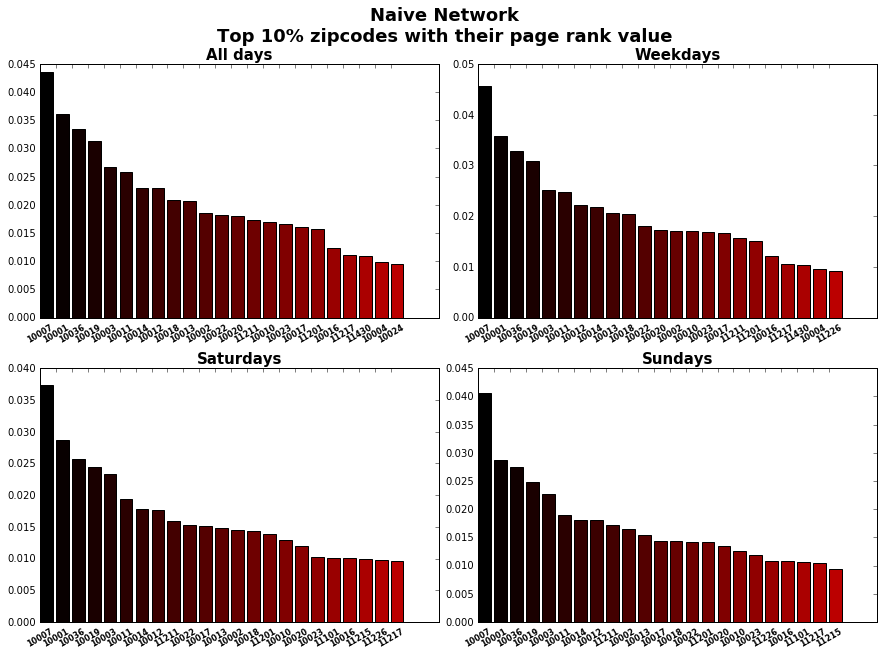

In [199]:
TopZipNaive, TopZipProb = range(4), range(4)
fig4 = plt.figure(num = 4, figsize = (15,10))
plt.suptitle('Naive Network\nTop %d%% zipcodes with their page rank value'%TopPercent, fontweight="bold", size=18)
for i in range(4):
    TopZipNaive[i] = TopZipCode(fig4, PR1[i], i, Top)

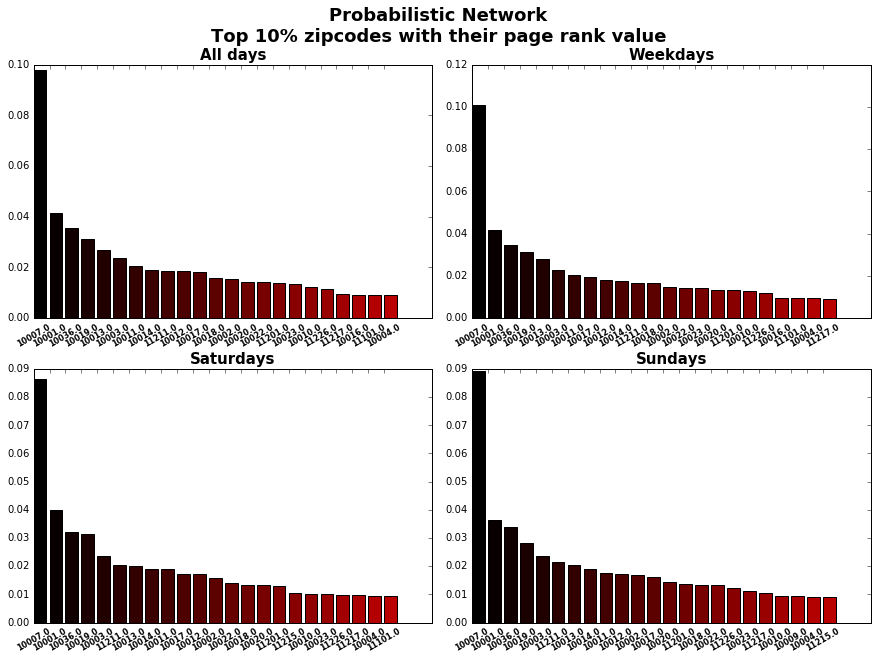

In [200]:
fig5 = plt.figure(num = 5, figsize = (15,10))
plt.suptitle('Probabilistic Network\nTop %d%% zipcodes with their page rank value'%TopPercent, fontweight="bold", size=18)
for i in range(4):
    TopZipProb[i] = TopZipCode(fig5, PR2[i], i, Top)

## Next we try page rank algorithm to see if it can provide anything interesting, we will compare our probabilistic network with naive networks

In [203]:
def PlotPageRankPart(fig, partition, TopZip, date_index=0, zips=geo_NY, key='postalCode', cmap='YlOrRd', title='Community Detection',size=221, alpha=.7):
    ax = fig.add_subplot(size + date_index)
    p = pd.Series(partition).reset_index().rename(columns={'index':'postalCode',0:'part'})
    zips.postalCode = zips.postalCode.astype(int)
    z = zips.merge(p, on=key, how='left')
    z[z.part.notnull()].plot(column = 'part', ax=ax, alpha=alpha, cmap = cmap, categorical=1, legend = 0)
    z[z.postalCode.isin(TopZip[date_index])].plot(ax=ax, alpha=alpha, color = 'k', categorical=1, legend = 0)
    plt.title(title, fontweight="bold", size=15)
    ax.axis('off')
    plt.subplots_adjust(hspace = 0.1, wspace = 0)

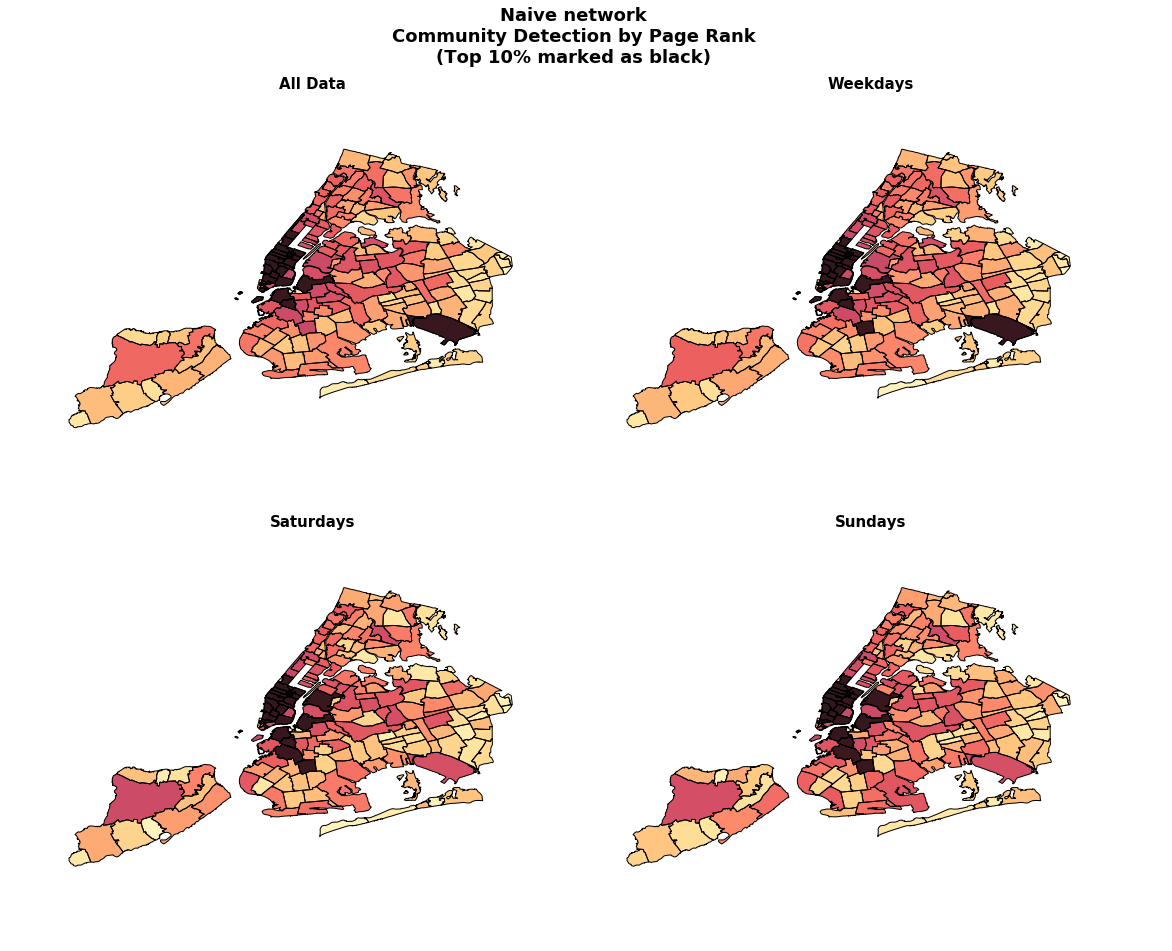

In [204]:
fig20 = plt.figure(num = 20, figsize = (20,15))
plt.suptitle('Naive network\nCommunity Detection by Page Rank\n(Top %d%% marked as black)'%TopPercent, fontweight="bold", size=18)
for i in range(4):
    PlotPageRankPart(fig20, PR1[i], TopZipNaive, date_index=i, title = Title[i])

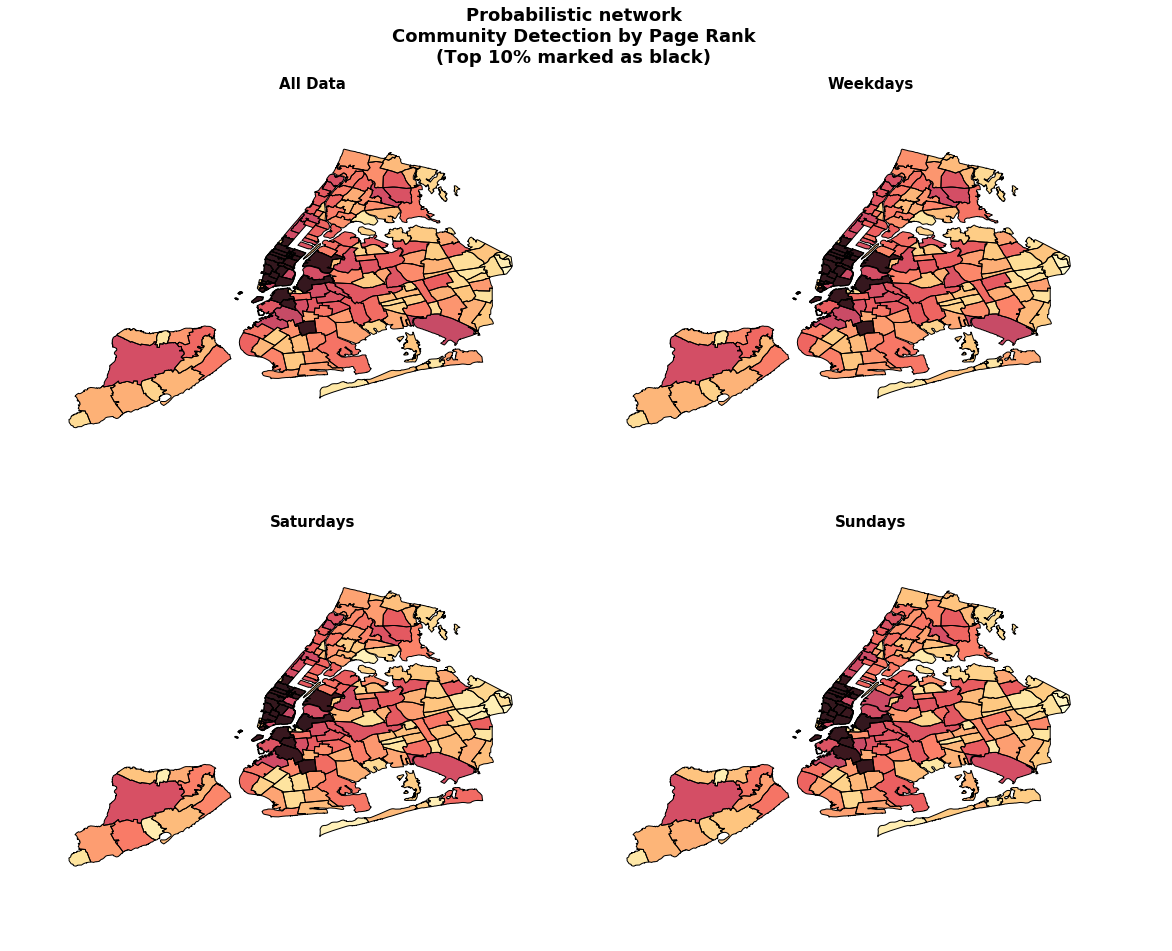

In [205]:
fig21 = plt.figure(num = 21, figsize = (20,15))
plt.suptitle('Probabilistic network\nCommunity Detection by Page Rank\n(Top %d%% marked as black)'%TopPercent, fontweight="bold", size=18)
for i in range(4):
    PlotPageRankPart(fig21, PR2[i], TopZipProb, date_index=i, title = Title[i])

### C) Some demographic data of New York gathered in 2014

In [35]:
Demographic = pd.read_csv(PWD + "/Demographic_2014.csv", low_memory=False)
variable_names = list(Demographic.iloc[0,:])
#first row is variable name
Demographic = Demographic.iloc[1:,:]
Demographic.index = range(len(Demographic))
#get zipcode from the strange string
zipcode = pd.DataFrame([int(Demographic.loc[i,'Name of Area'].split(" ")[0]) for i in range(len(Demographic))])
Demographic.columns = variable_names
Demographic = pd.concat((zipcode,Demographic),axis=1)
Demographic = Demographic.rename(columns={0:'zipcode'})

* Slice and simplify the dataframe according to our zipcode database so we can focus on New York instead of the whole country

In [36]:
Demo_NY = Demographic[Demographic.zipcode.isin(Data[0].ZipCode.unique())]

## First plotting the sample base, which is the "All days" category, then we observe if there's any interesting features showing on each community based on our partition

fig4 = plt.figure(num = 4, figsize = (20,15))
plt.suptitle('Figure 4(Loop edges included)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig4, D_Graph2[i], CP4[i],i)

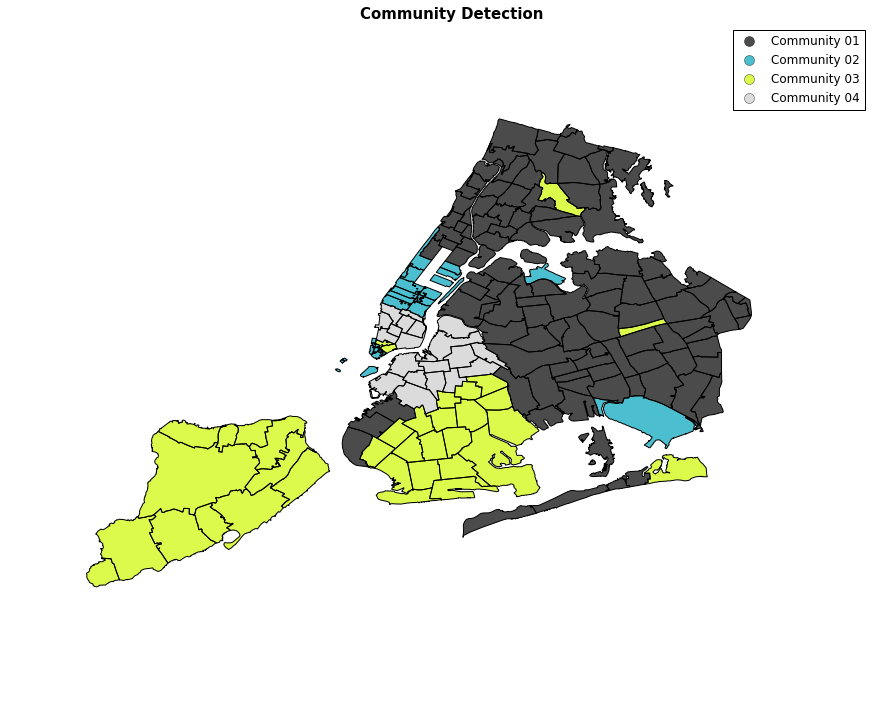

In [220]:
fig5 = plt.figure(figsize = (15,12))
PlotMapPart(fig5, SP_CP4[0], size = 111, alpha = 0.7)

### Since the demographic data provides only number regarding population, and the area of each territory plays a more crucial role here, comparing populatin doesn't make much sense. Instead, we normalize it by dividing the population, and then compare the percentage.
### The formulae for such weighted average are:
$$mean=\frac{\sum_z p(z)pop(z)}{\sum_z pop(z)}$$
$$std=\sqrt{\frac{\sum_z (p(z)-mean)^2}{\sum_z pop(z)}}$$
### where p(z), pop(z) denote the percent and population, respectively

In [65]:
def ShowFeature(feature_name, sorted_partition, LEGEND = None, title = 'Community Data', date_index = 0):
    '''date_index has the similar function here: controlling the sample base
    0--All days
    1--Weekdays
    2--Saturdays
    3--Sundays
    with 0 being the default'''
    #please make sure to use sorted_partition so that ClusterRanking is no longer needed
    partition = sorted_partition[date_index]
    feature_len = len(feature_name)
    data = Demo_NY.loc[:,feature_name]
    data.fillna(value = 0, inplace=True)
    data = data.applymap(int)
    data['ZipCode'] = Demo_NY.zipcode
    #zip_intersection = set(data.ZipCode) & set(partition.keys())
    data = data[data.ZipCode.isin(set(partition.keys()))]
    data['Part'] = [partition[i] for i in data.ZipCode]
    grouped = data.iloc[:,:-2].groupby(data.Part)
    SUM = grouped.sum()*1.0
    RATIO = SUM.divide(sum(SUM, axis = 1), axis = 0)
    STD = grouped.std()
    MEAN = grouped.mean()
    level = len(set(partition.values()))
    Width = 3.0/feature_len/level
    fig = plt.figure(figsize = (20, 9))
    x = range(level)
    LABEL = ['Community %d%d'%((i+1)/10,(i+1)%10) for i in x] 
    bar_step = arange(0, feature_len)
    Color = matplotlib.cm.spectral(np.linspace(0,1,feature_len+1))
    ax = fig.add_subplot(111)
    for i in range(feature_len):
        plt.bar(x+bar_step[i]*Width, MEAN.iloc[:,i] ,width = Width, yerr = list(STD.iloc[:,i]), color = Color[i+1], align='center')
    Title = ['ALL days','Weekdays', 'Saturdays', 'Sundays']
    plt.title(title+' data on each community (Partition based on '+Title[date_index]+')', fontweight="bold", size = 18)
    y = [i+(feature_len-1)*0.5*Width for i in x]
    ax.set_xticks(y)
    ax.set_xticklabels(LABEL, fontsize = 14, fontweight="bold")
    if LEGEND != None:
        plt.legend(LEGEND, fontsize = 18-feature_len/2, loc =2)
    plt.show()

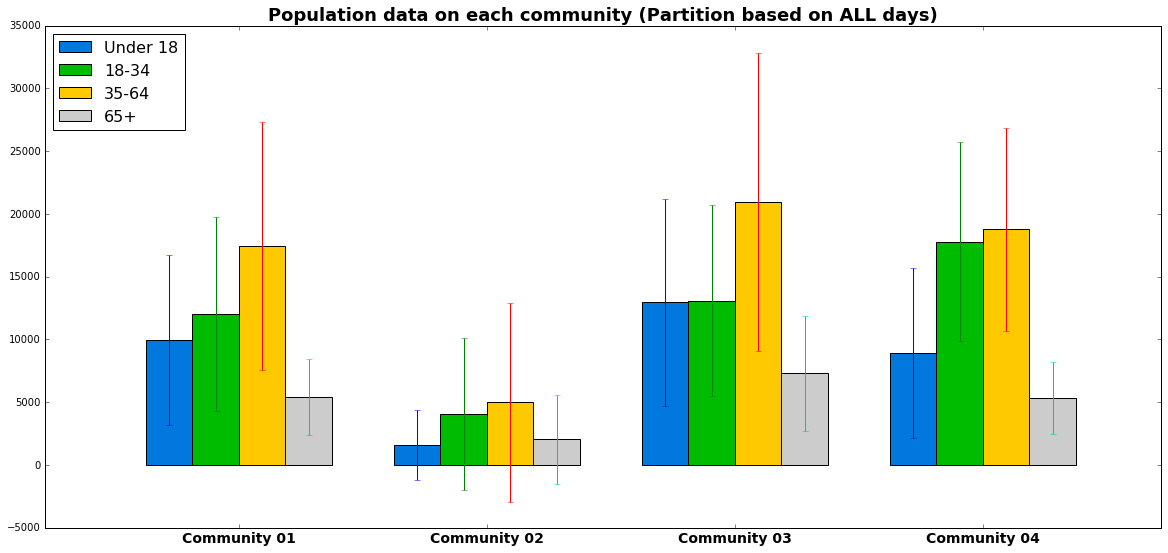

In [66]:
population = ['SE_T009_002','SE_T009_003','SE_T009_004','SE_T009_005']
legend_pop = ['Under 18', '18-34', '35-64', '65+']
#'SE_T001_001' is the Total population
ShowFeature(population,SP_CP4,legend_pop,'Population')

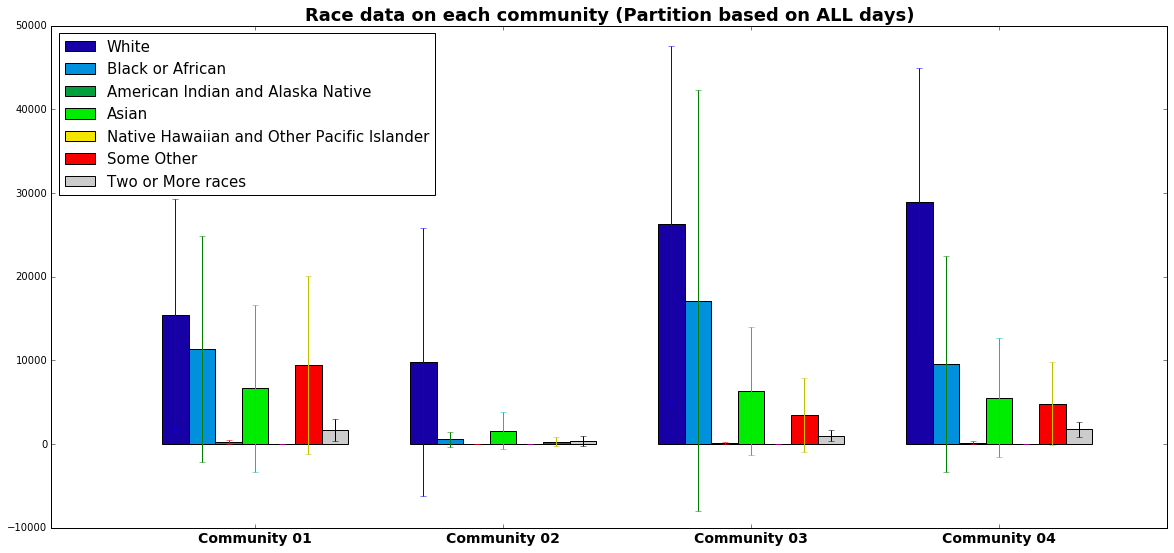

In [67]:
race = ['SE_T013_002','SE_T013_003','SE_T013_004','SE_T013_005','SE_T013_006','SE_T013_007','SE_T013_008']
legend_race = ['White', 'Black or African', 'American Indian and Alaska Native', 'Asian',
            'Native Hawaiian and Other Pacific Islander', 'Some Other', 'Two or More races']
#'SE_T013_001' is the Total population
ShowFeature(race,SP_CP4,legend_race,'Race')

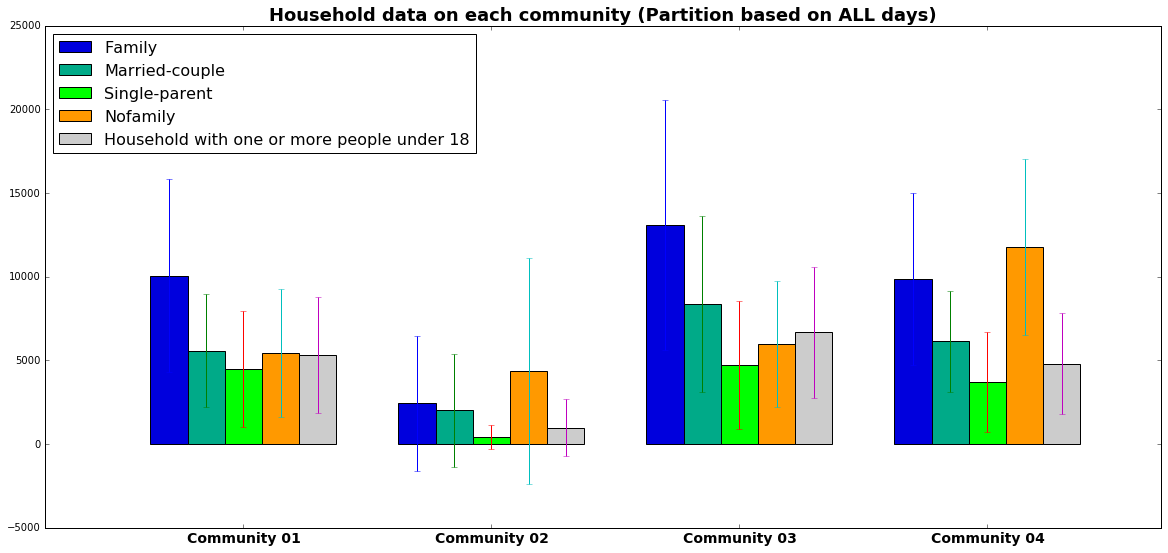

In [68]:
households = ['SE_T017_002','SE_T017_003','SE_T017_004','SE_T017_007','SE_T018_002']
legend_households = ['Family', 'Married-couple', 'Single-parent', 'Nofamily',
                     'Household with one or more people under 18']
#'SE_T017_001' is the Total Households
ShowFeature(households,SP_CP4,legend_households,'Household')

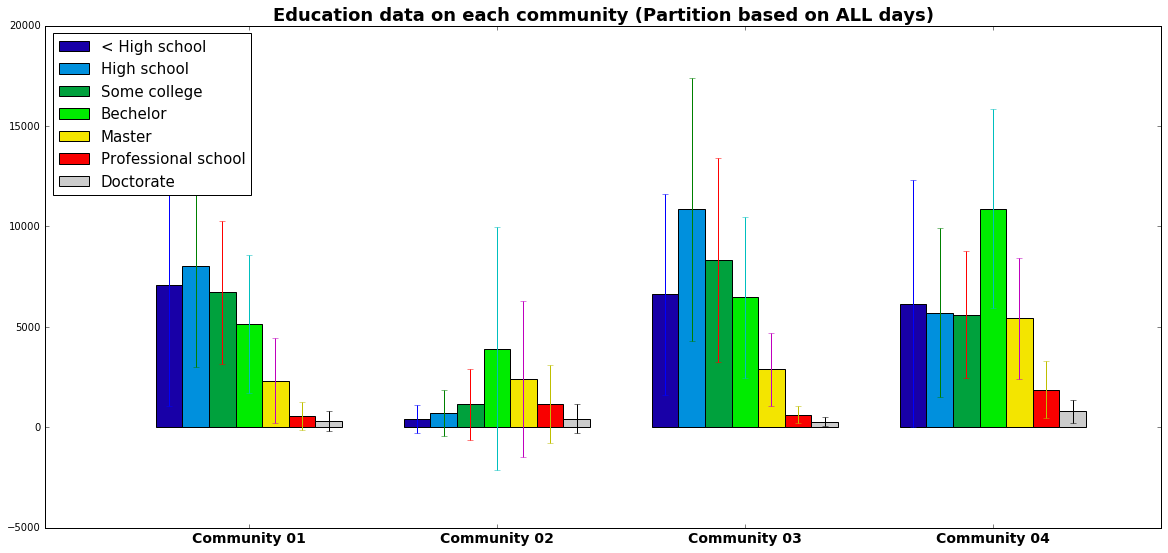

In [69]:
education = ['SE_T025_002','SE_T025_003','SE_T025_004','SE_T025_005','SE_T025_006','SE_T025_007','SE_T025_008']
legend_edu = ['< High school','High school', 'Some college', 'Bechelor', 'Master', 'Professional school', 'Doctorate']
# 'SE_T025_001'is the Total Population over 25
ShowFeature(education,SP_CP4,legend_edu,'Education')

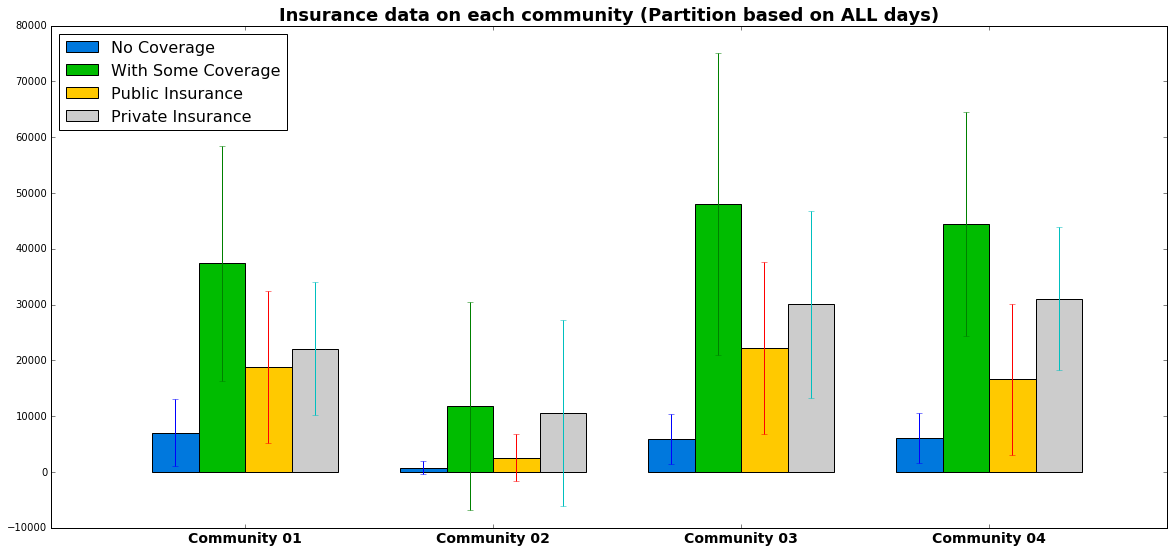

In [70]:
insurance=['SE_T145_002','SE_T145_003','SE_T145_004','SE_T145_005']
#'SE_T145_001' is the Total number, and 
legend_insur = ['No Coverage','With Some Coverage', 'Public Insurance', 'Private Insurance']
ShowFeature(insurance,SP_CP4,legend_insur,'Insurance')

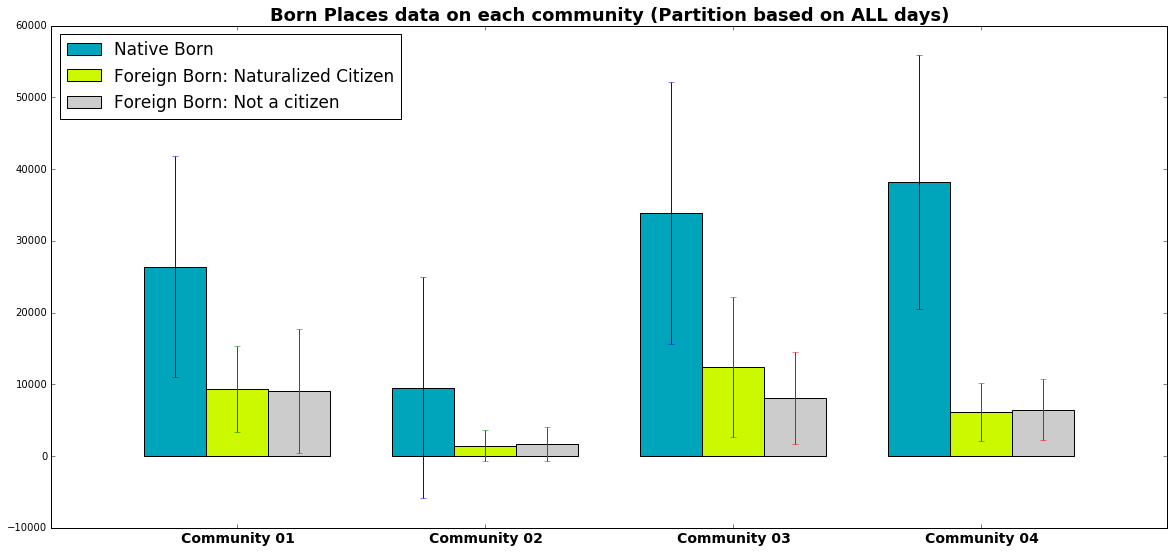

In [71]:
born_place = ['SE_T133_002','SE_T133_004','SE_T133_005']
legend_born = ['Native Born','Foreign Born: Naturalized Citizen', 'Foreign Born: Not a citizen']
#'SE_T133_001' Total Population; 'SE_T133_003',Foreign Born
ShowFeature(born_place, SP_CP4,legend_born,'Born Places')

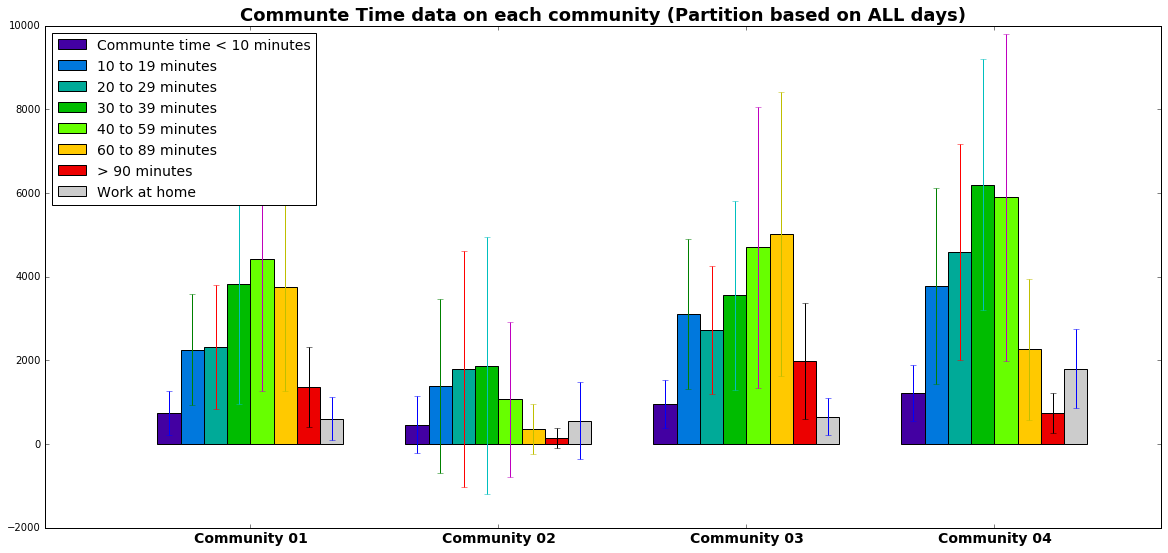

In [72]:
commute_time = ['SE_T129_003','SE_T129_004','SE_T129_005',
                     'SE_T129_006','SE_T129_007','SE_T129_008','SE_T129_009','SE_T129_010']
# 'SE_T129_001', Workers 16 Years and over; 'SE_T129_002', did not work at home
legend_commute_time = ['Communte time < 10 minutes','10 to 19 minutes','20 to 29 minutes','30 to 39 minutes',
                       '40 to 59 minutes','60 to 89 minutes','> 90 minutes', 'Work at home']
ShowFeature(commute_time,SP_CP4,legend_commute_time,'Communte Time')

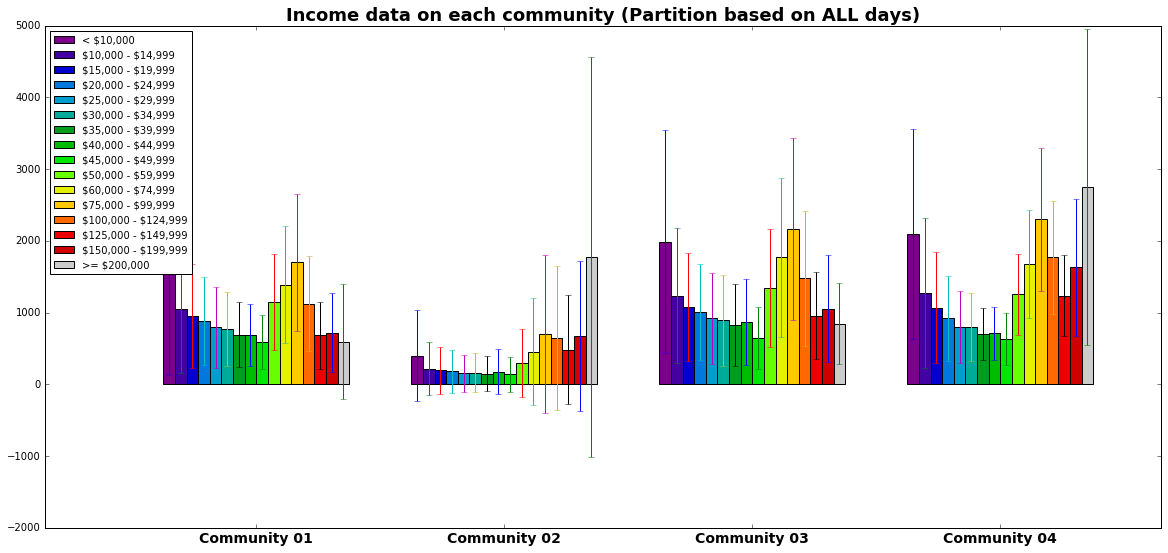

In [73]:
income=['SE_T056_002','SE_T056_003','SE_T056_004','SE_T056_005','SE_T056_006','SE_T056_007',
       'SE_T056_008','SE_T056_009','SE_T056_010','SE_T056_011','SE_T056_012','SE_T056_013',
       'SE_T056_014','SE_T056_015','SE_T056_016','SE_T056_017']
#'SE_T056_001' is the number of total Households
legend_income = ['< $10,000','\$10,000 - $14,999', '\$15,000 - $19,999', '\$20,000 - $24,999', '\$25,000 - $29,999',
                 '\$30,000 - $34,999', '\$35,000 - $39,999', '\$40,000 - $44,999', '\$45,000 - $49,999',
                 '\$50,000 - $59,999','\$60,000 - $74,999','\$75,000 - $99,999', '\$100,000 - $124,999',
                 '\$125,000 - $149,999','\$150,000 - $199,999', '>= $200,000']
ShowFeature(income, SP_CP4,legend_income,'Income')

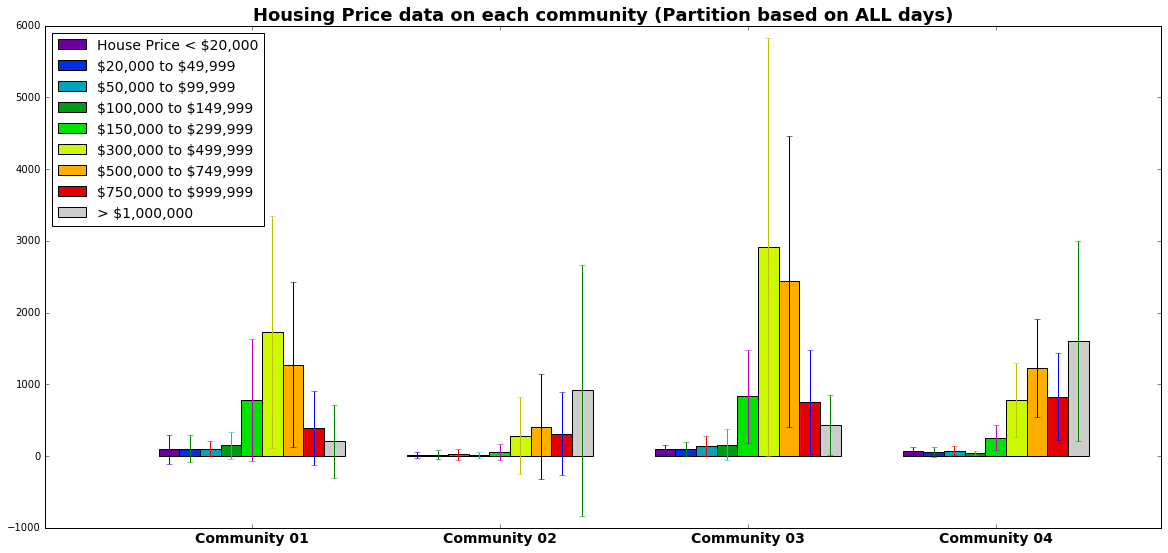

In [74]:
House_price =['SE_T100_002','SE_T100_003','SE_T100_004','SE_T100_005',
                  'SE_T100_006','SE_T100_007','SE_T100_008','SE_T100_009','SE_T100_010']
legend_house_price = ['House Price < $20,000','\$20,000 to $49,999','\$50,000 to $99,999','\$100,000 to $149,999',
                      '\$150,000 to $299,999','\$300,000 to $499,999','\$500,000 to $749,999','\$750,000 to $999,999',
                      '> $1,000,000']
#'SE_T100_001', Owner-occupied housing units
ShowFeature(House_price,SP_CP4,legend_house_price,'Housing Price')

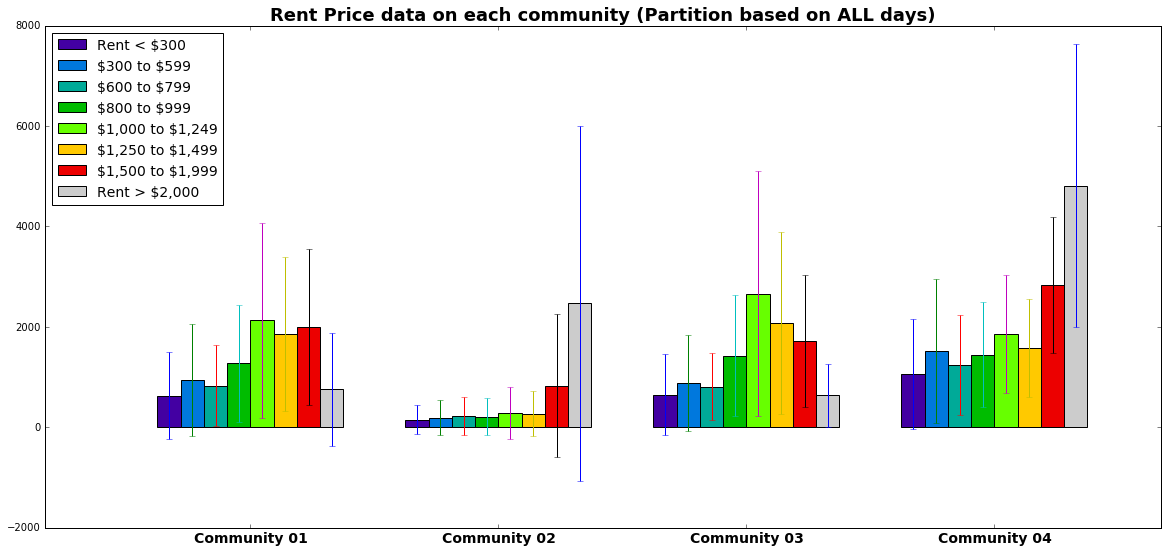

In [75]:
Rent_price=['SE_T102_002','SE_T102_003','SE_T102_004','SE_T102_005',
            'SE_T102_006','SE_T102_007','SE_T102_008','SE_T102_009']
#'SE_T102_001', Renter-occupied housing units with cash rent
legen_rent_price = ['Rent < $300','\$300 to $599','\$600 to $799','\$800 to $999','\$1,000 to $1,249',
                    '\$1,250 to $1,499','\$1,500 to $1,999','Rent > $2,000']
ShowFeature(Rent_price, SP_CP4,legen_rent_price,'Rent Price')

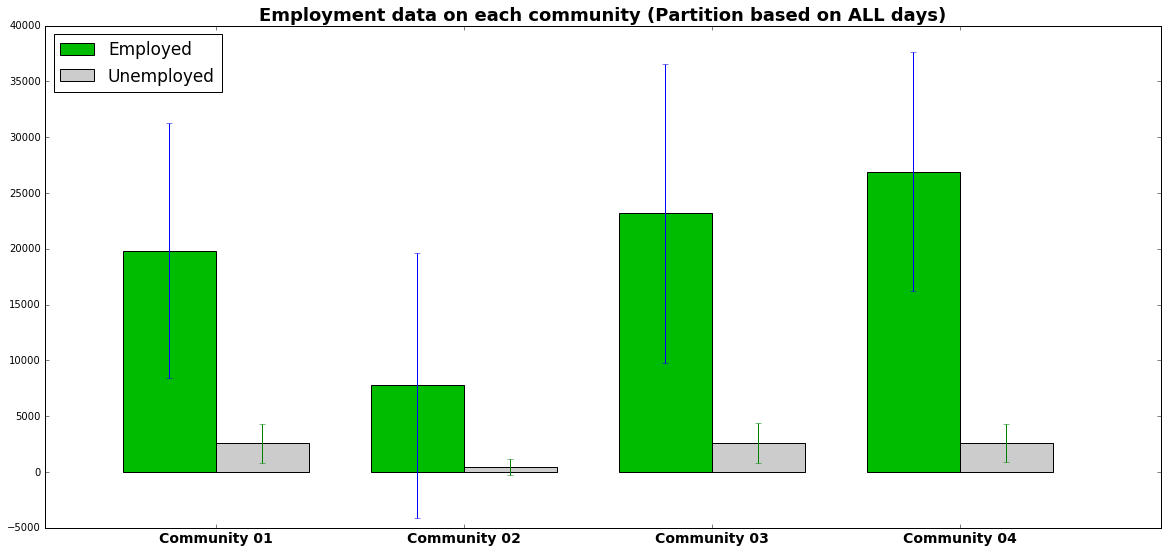

In [76]:
employment = ['SE_T037_002','SE_T037_003']
legend_emp = ['Employed', 'Unemployed']
# 'SE_T037_001' is the total Civilian Population In Labor Force 16 Years And Over
ShowFeature(employment,SP_CP4,legend_emp,'Employment')

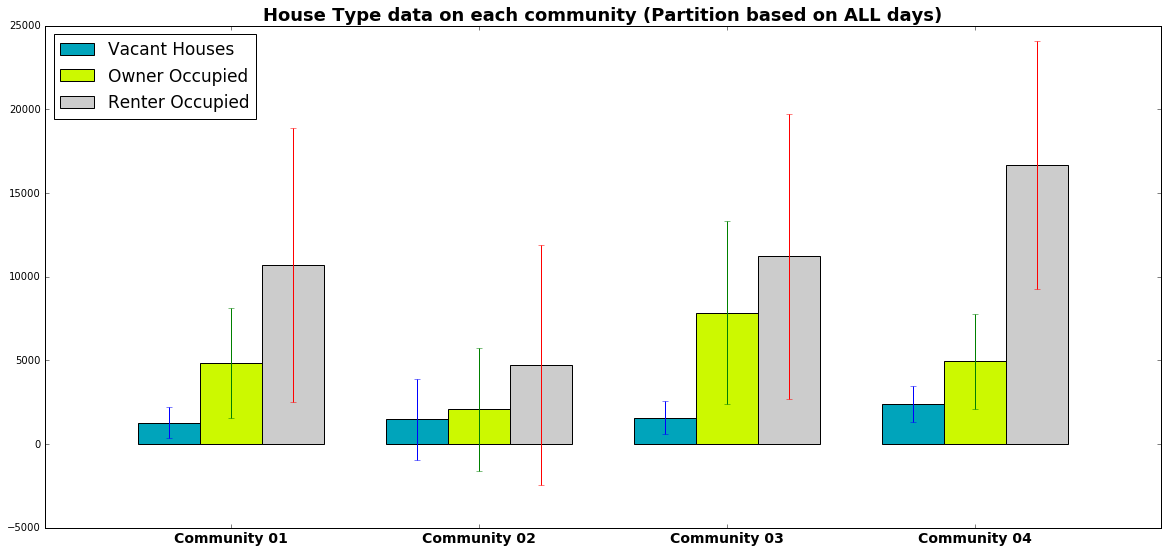

In [77]:
type_house = ['SE_T095_003','SE_T094_002','SE_T094_003']
legend_housetype = ['Vacant Houses','Owner Occupied','Renter Occupied']
#'SE_T094_001','Occupied houses'
ShowFeature(type_house, SP_CP4,legend_housetype,'House Type')

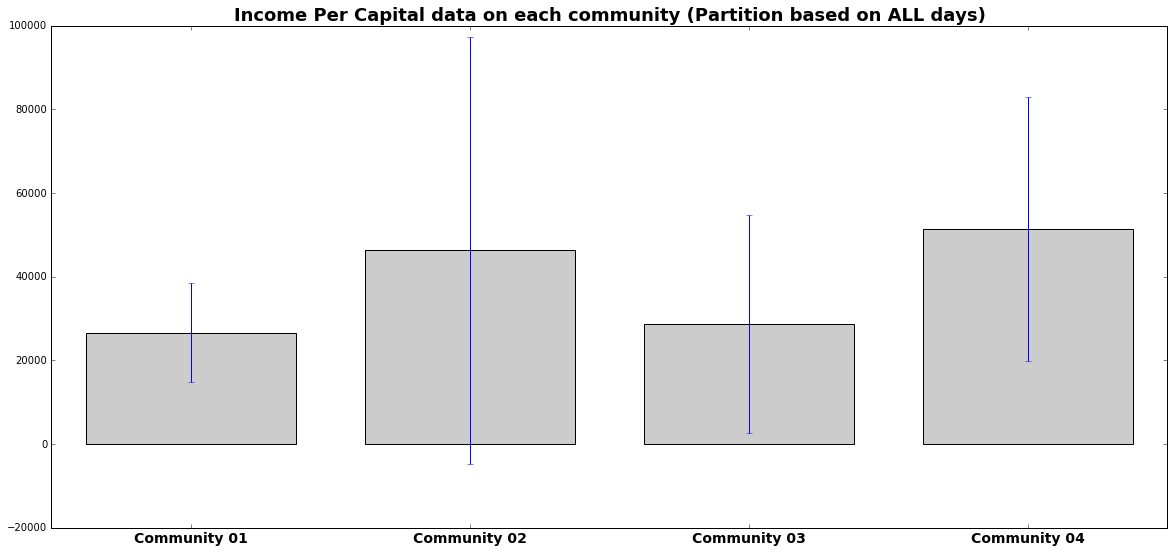

In [78]:
income_per_capital=['SE_T083_001']
#legend_income_per_cap = ['Income Per Capital']
#Per capita income (In 2014 Inflation adjusted dollars)
ShowFeature(income_per_capital,SP_CP4,title='Income Per Capital')

### D) Gravitional Test